<a href="https://colab.research.google.com/github/ThousandAI/Application-of-AI/blob/main/class04/class04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolution**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "./drive/MyDrive/Colab-Notebooks/Application-of-AI/class04/cat.jpg"

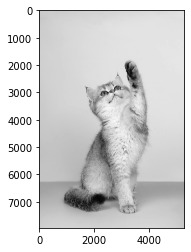

In [4]:
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap = 'gray')
plt.show()

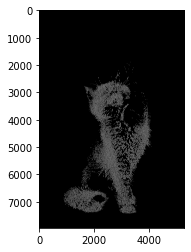

In [10]:
canny = cv2.Canny(img, 20, 100)
plt.imshow(canny, cmap = 'gray')
plt.show()

## CNN Model

In [14]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
BATCH_SIZE = 64
num_classes = 10
epochs = 10
learning_rate = 1e-4 # 0.0001

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



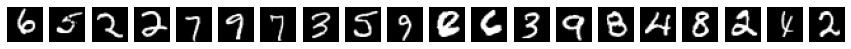

In [13]:
# Dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE, shuffle = False)
iterator = iter(train_loader)
images, labels = next(iterator)
fig, axes = plt.subplots(1,20, figsize=(15, 15))
for i in range(20):
  axes[i].imshow(images[i][0], cmap = 'gray')
  axes[i].set_axis_off()
fig.show()

In [17]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) # 32x28x28
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1) # 32x28x28
    self.pool1 = nn.MaxPool2d(2,2) # 32x14x14
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 64x14x14
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1) # 64x14x14
    self.pool2 = nn.MaxPool2d(2,2) # 64x7x7
    self.fc1 = nn.Linear(64*7*7,512)
    self.fc2 = nn.Linear(512,10)
   
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool1(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool2(x)
    x = x.view(-1,64*7*7)
    x = F.relu(self.fc1(x))
    output = self.fc2(x)
    return output

In [18]:
cnn = ConvNet().to(device)
print(cnn)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [21]:
n_total_steps = len(train_loader)
for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [64, 1, 28, 28]
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [100/938], Loss: 0.5753
Epoch [1/10], Step [200/938], Loss: 0.3733
Epoch [1/10], Step [300/938], Loss: 0.2120
Epoch [1/10], Step [400/938], Loss: 0.3009
Epoch [1/10], Step [500/938], Loss: 0.2500
Epoch [1/10], Step [600/938], Loss: 0.0958
Epoch [1/10], Step [700/938], Loss: 0.2346
Epoch [1/10], Step [800/938], Loss: 0.2639
Epoch [1/10], Step [900/938], Loss: 0.1761
Epoch [2/10], Step [100/938], Loss: 0.0764
Epoch [2/10], Step [200/938], Loss: 0.1308
Epoch [2/10], Step [300/938], Loss: 0.0896
Epoch [2/10], Step [400/938], Loss: 0.0205
Epoch [2/10], Step [500/938], Loss: 0.0361
Epoch [2/10], Step [600/938], Loss: 0.0162
Epoch [2/10], Step [700/938], Loss: 0.0620
Epoch [2/10], Step [800/938], Loss: 0.0788
Epoch [2/10], Step [900/938], Loss: 0.0180
Epoch [3/10], Step [100/938], Loss: 0.1318
Epoch [3/10], Step [200/938], Loss: 0.0351
Epoch [3/10], Step [300/938], Loss: 0.1371
Epoch [3/10], Step [400/938], Loss: 0.0558
Epoch [3/10], Step [500/938], Loss: 0.0503
Epoch [3/10

In [22]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = cnn(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 98.92 %
